In [35]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [36]:
from IPython.display import IFrame

IFrame(width=560, height=315, src="https://www.youtube.com/embed/zSOMeug_i_M")

## Grid World

Here I define a simple grid world environment

<IPython.core.display.Javascript object>


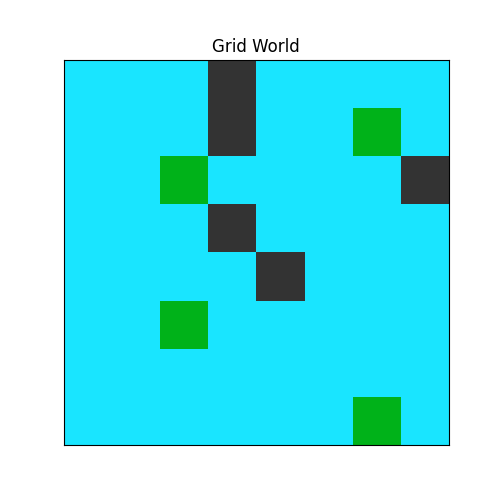

In [37]:
from enum import Enum
from typing import Tuple

%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np


class Actions(Enum):
    UP = 0
    RIGHT = 1
    DOWN = 2
    LEFT = 3


class GridWorld:
    """
    Grid world which has solid ground, holes, and goals. Solid ground gives 0
    reward, holes give negative reward, goals give positive reward.
    """
    
    def __init__(self, height: int, width: int, num_goals=1, num_holes=0,
                 goal_reward: float = 1., hole_reward: int = -1.):
        self.shape = (height, width)
        self.hole_reward = hole_reward
        self.goal_reward = goal_reward
        # Reward is given whenever we land in a grid cell. By default
        # reward is zero
        self.rewards = np.zeros(shape=(height, width))
        # Set goals and holes
        indices = np.random.choice(
            np.arange(height*width), size=num_goals+num_holes)
        goal_indices = indices[:num_goals]
        hole_indices = indices[num_goals:]
        self.rewards[
            np.unravel_index(goal_indices, (height, width))] = goal_reward
        self.rewards[
            np.unravel_index(hole_indices, (height, width))] = hole_reward        

    def evaluate_state_action(self, state: Tuple[int, int], action: Actions):
        """
        Get the expected reward and next state probablities for taking an
        `action` while in an initial `state`
        The next state probabilities are represented in a dictionary. Keys are
        tuples of (y, x co-ords) and values are the associated probabilities.
        This method assumes we have a model of the environment, therefore we
        can compute the expected reward analytically
        For now the action has a deterministic outcome.
        TODO Implement non-deterministic outcomes
        """
        new_y = state[0]
        new_x = state[1]
        if action == Actions.UP:
            new_y = max(new_y - 1, 0)
        elif action == Actions.RIGHT:
            new_x = min(new_x + 1, self.shape[1] - 1)
        elif action == Actions.DOWN:
            new_y = min(new_y + 1, self.shape[0] - 1)
        elif action == Actions.LEFT:
            new_x = max(new_x - 1, 0)
        next_state_probabilities = {(new_y, new_x): 1.}
        reward = self.rewards[new_y, new_x]
        return next_state_probabilities, reward

    def render(self):
        """
        Blue for solid ground
        Green for goals
        Black for holes
        """
        grid = np.zeros((*self.shape, 3)) + np.array([0.1, 0.9, 1])
        # Color in the goals
        grid[np.where(self.rewards == self.goal_reward)] = np.array([0, 0.7, 0.1])
        # Color in holes
        grid[np.where(self.rewards == self.hole_reward)] = np.array([0.2, 0.2, 0.2])
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.imshow(grid, vmin=0, vmax=1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title("Grid World")
        fig.canvas.draw()

env = GridWorld(8, 8, num_goals=5, num_holes=5)
env.render()

## Policy specification

Specification for how policies should be defined, and a helper for visualization.

<IPython.core.display.Javascript object>


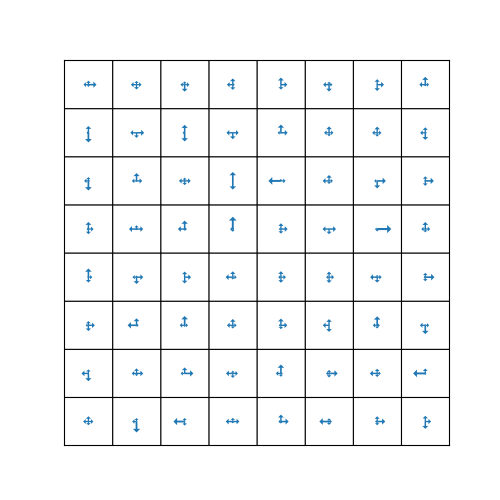

In [38]:
class PolicyHelper:
    """
    Use this to define policies for the purposes of this notebook
    """
    def __init__(self, env: GridWorld, policy: np.ndarray):
        # `policy` is a 3d array (following the shape of the environment)
        # The first two dimensions are the spatial dimensions, and the last
        # dimension represents the probability of taking up, right, down, left
        # as an action
        self.env = env
        self.policy = policy
    
    @classmethod
    def uniformly_random(cls, env: GridWorld):
        policy = np.random.uniform(size=(*env.shape, len(Actions)))
        policy = policy / policy.sum(-1)[:, :, None]  # normalize
        return cls(env, policy)

    @classmethod
    def uniform(cls, env: GridWorld, action: Actions):
        policy = np.zeros(shape=(*env.shape, len(Actions)))
        policy[:, :, action.value] = 1
        return cls(env, policy)

    def render(self, figure_title: str = '', redraw=False):
        """
        Draw a grid of arrows with magnitudes representing
        the probability of taking an action
        """
        res = 40  # kind of like resolution
        grid = np.ones((env.shape[0]*res, env.shape[1]*res, 3))
        grid[:, res::res] *= 0
        grid[res::res] *= 0
        if redraw:
            self.ax.clear()
        else:
            self.fig, self.ax = plt.subplots(figsize=(5, 5))
        self.ax.imshow(grid, vmin=0, vmax=1)
        self.ax.set_xticks([])
        self.ax.set_yticks([])
        if len(figure_title):
            self.ax.set_title(figure_title)
        for ix, p in np.ndenumerate(self.policy):
            if p > 0:
                plt.arrow(
                    x = ix[1]*res + res/2, y= ix[0]*res + res/2,
                    dx = p * 0.4 * res * [0, 1, 0, -1][ix[2]],
                    dy = p * 0.4 * res * [-1, 0, 1, 0][ix[2]],
                    length_includes_head=True, width=0.05*res*np.sqrt(p),
                    head_length=0.1*res*np.sqrt(p),
                    head_width=0.2*res*np.sqrt(p), linewidth=0)
        self.fig.canvas.draw()


env = GridWorld(8, 8, num_goals=5, num_holes=5)
policy_helper = PolicyHelper.uniformly_random(env)
# policy_helper = PolicyHelper.uniform(env, action=Actions.DOWN)
policy_helper.render()

## Policy evaluation

In the next cell I demonstrate
1. How to evalute the policy exactly by solving a linear system of equations derived from applying Bellman's equation to all states.
2. How to evaluate the policy with dynamic programming.
3. Applying the above to a randomly generated gridworld and checking that values from both methods are the same.

<IPython.core.display.Javascript object>


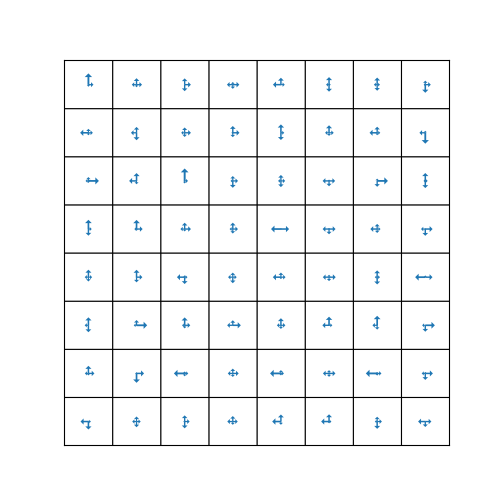

<IPython.core.display.Javascript object>


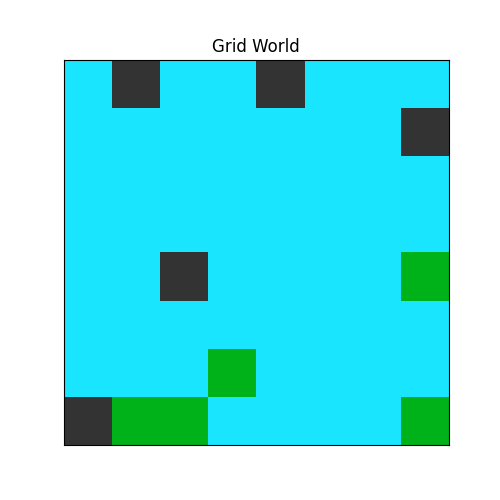

<IPython.core.display.Javascript object>


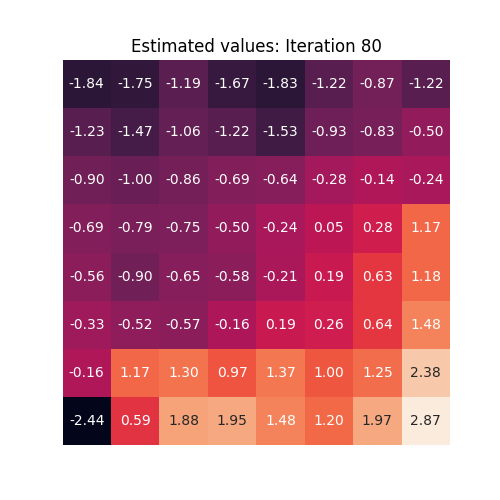

Policy evaluation did converge


<IPython.core.display.Javascript object>


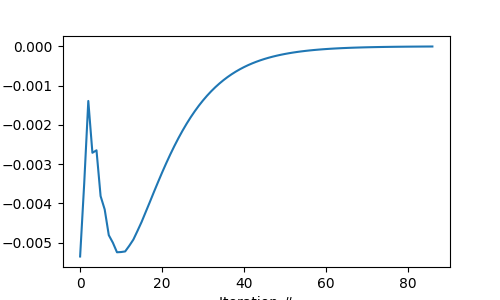

✓ Values from policy evaluation DO match the analytical solution


In [39]:
from typing import Optional
from time import sleep

import seaborn as sns


def evaluate_policy_analytically(env: GridWorld, policy: np.ndarray, gamma: float):
    """
    Evaluate policy by solving system of linear equations
    If you are having trouble understanding the computation of expectation
    values, this video might help https://youtu.be/uUoGPvxPkQU
    """
    # `coeffs` will be a numpy array of coefficients for each state-value
    # `consts` will store the constant terms
    coeffs = []
    consts = []
    # Look at the Bellman equation for each state
    # Reminder of Bellman eqn
    # v(s) = sum_a(
    #     pi(a|s) * sum_r,s'(
    #         p(r, s' | s, a) * (r + gamma * v(s'))
    #     )
    # )
    # or compactly: v(s) = E[R_{t+1} + gamma * v(S_{t+1}) | s, pi]
    for ravelled_state_ix in range(np.prod(env.shape)):
        # Expectation value of reward given current state and policy
        # aka E[R_{t+1} | s, pi]
        er_sp = 0
        # Initialise next set of coefficients...
        coeffs.append(np.zeros(np.prod(env.shape)))
        # ... remembering that we need to set the coefficient for the current state
        coeffs[-1][ravelled_state_ix] = 1
        # Convert index to grid world coords
        state_ix = np.unravel_index(ravelled_state_ix, env.shape)
        # Step through outer sum of Bellman eqn
        for action in Actions:
            # Probability of action
            p_a = policy[state_ix][action.value]
            if p_a == 0:
                continue
            # `er_sa` is the expectation value of reward given state and action
            # aka E[R_{t+1} | s, a]
            next_state_probabilities, er_sa = env.evaluate_state_action(
                state_ix, action)
            # Add to the series expansion of er_sp
            er_sp += p_a * er_sa
            
            # Step through inner sum of Bellman eqn for next state probs
            for next_state_ix, p_s in next_state_probabilities.items():
                # Add to the series expansion of coefficients
                # We use a -ve sign because we need to move coefficients to LHS of Bellman
                coeffs[-1][np.ravel_multi_index(next_state_ix, env.shape)] \
                    -= p_a * p_s * gamma
        consts.append(er_sp)
        
    consts = np.array(consts)
        
    return np.linalg.solve(coeffs, consts).reshape(*env.shape)
             


class DynamicPolicyEvaluator:
    def __init__(self, env: GridWorld, policy: np.ndarray):
        self.env = env
        self.update_policy(policy)

    def update_policy(self, policy: np.ndarray):
        self.policy = policy
    
    def evaluate(self, gamma: float, num_iterations: Optional[int] = None,
                 init_values: Optional[np.ndarray] = None,
                 vis_interval: Optional[int] = None):
        """
        Must specify gamma as the discount factor
        Specifying `iterations` will go for that many iterations or till
        convergence (whichever comes first)
        If you are having trouble understanding the computation of expectation
        values, this video might help https://youtu.be/uUoGPvxPkQU
        """
        # Store whether the evaluation converged
        converged = False
        # Initialize values if they are not provided
        if init_values is None:
            values = np.zeros(self.env.shape)
        else:
            values = init_values.copy()
        # One time step goes through all states in the policy and does an
        # update on the estimated value
        # Stopping condition is either `num_iterations` being reached or ALL
        # estimated values having converged
        k = 0  # iteration counter
        avg_diffs = [] # store average diff to visualize convergence
        # Will keep a copy of previous values each iteration to check convergence
        prev_values = values.copy()  
        while True:
            new_values = np.zeros_like(values)
            for state_ix, _ in np.ndenumerate(values):
                # Expectation value of reward given current state and policy
                # aka E[R_{t+1} | s, pi]
                er_sp = 0
                # Expectation value of state-value of next state given current state and policy
                # aka E[v(S_{t+1}) | s, pi]
                ev_sp = 0
                # Compute by expanding the expectation values over all possible actions
                for action in Actions:
                    # Probability of action
                    p_a = self.policy[state_ix][action.value]
                    if p_a == 0:
                        continue
                    # `er_sa` is the expectation value of reward given state and action
                    # aka E[R_{t+1} | s, a]
                    next_state_probabilities, er_sa = self.env.evaluate_state_action(
                        state_ix, action)
                    # Compute `ev_sa` aka E[v(S_{t+1}) | s, a]
                    ev_sa = 0
                    for next_state_ix, p_s in next_state_probabilities.items():
                        ev_sa += p_s * values[next_state_ix]
                    # Add to the series expansion of er_sp
                    er_sp += p_a * er_sa
                    # Add to the series expansion of ev_sp
                    ev_sp += p_a * ev_sa
                # Fill new values with update rule
                new_values[state_ix] = er_sp + gamma * ev_sp
            # Update values
            values = new_values.copy()
            # Update the average diff in values
            avg_diffs.append((values - prev_values).mean())
            k += 1
            # Visualize
            if vis_interval is not None and (k % vis_interval) == 0:
                self.render(values, figure_title=f'Estimated values: Iteration {k}',
                            redraw = (k > vis_interval))
                sleep(1)
            # Stop if num_iterations is reached
            if num_iterations is not None and k == num_iterations:
                break
            # Or if stopping condition is reached
            if prev_values is not None and np.allclose(prev_values, values, rtol=1e-4):
                converged = True
                break
            # Keep a copy of the values to check convergence
            prev_values = values.copy()
        return values, avg_diffs, converged

    def render(self, values, figure_title='', redraw=False):
        """
        Show grid with estimated values
        """
        if redraw:
            self.ax.clear()
        else:
            self.fig, self.ax = plt.subplots(figsize=(5, 5))
        sns.heatmap(values, ax=self.ax, cbar=False, annot=True, fmt='.2f')
        self.ax.set_xticks([])
        self.ax.set_yticks([])
        self.ax.set_title(figure_title)
        self.fig.canvas.draw()


GAMMA = 0.9
env = GridWorld(8, 8, num_goals=5, num_holes=5)
policy_helper = PolicyHelper.uniformly_random(env)
# policy_helper = PolicyHelper.uniform(env, Actions.DOWN)
analytical_solution = evaluate_policy_analytically(env, policy_helper.policy, GAMMA)
policy_helper.render()
env.render()
evaluator = DynamicPolicyEvaluator(env, policy_helper.policy)
# evaluator.render()
values, avg_diffs, converged = evaluator.evaluate(GAMMA, 200, vis_interval=10)
print(f"Policy evaluation did {'' if converged else 'not '}converge")

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(avg_diffs)
ax.set_xlabel('Iteration #')
ax.set_ylabel('Average of all value updates')
fig.canvas.draw()

if np.allclose(values, analytical_solution, atol=1e-04):
    print("✓ Values from policy evaluation DO match the analytical solution")
else:
    print("✘ Values from policy evaluation DO NOT match the analytical solution...")
    print(f"... max diff was {np.abs(values - analytical_solution).max()}")

## Policy Iteration

Making use of the DynamicPolicyEvaluator to do policy iteration via greedification. Will visualize how the policy changes over time.

Note that there seems to be a nice side-effect of the fact that running into a wall makes you stay on the spot. I did not even observe this myself until I was puzzled by the fact that the optimal policy does not try to return to the same goal patch if it is not near a wall. That's because the agent would only get the goal reward one in every two steps. But with a wall goal, the agent can get a reward for every step by running into the wall (and therefore staying on the spot). Try with a small gamma though (maybe 0.1) and you will find that sometimes the optimal thing to do IS to jump on and off a non-wall goal, if there is no wall goal nearby.

<IPython.core.display.Javascript object>


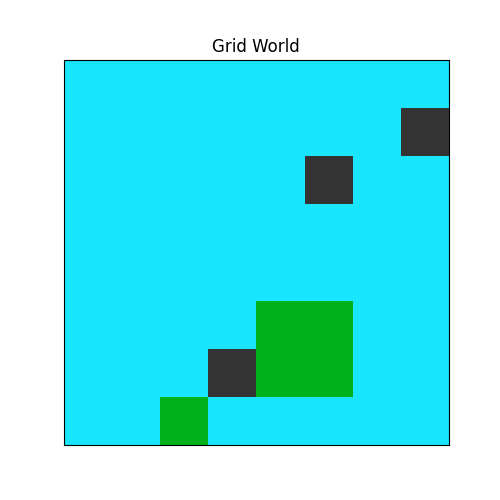

<IPython.core.display.Javascript object>


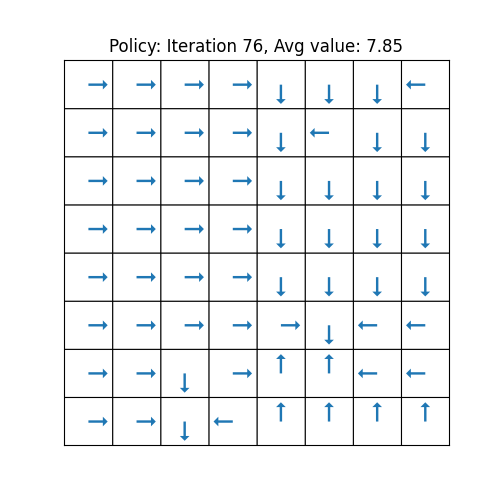

Policy iteration did converge


<IPython.core.display.Javascript object>


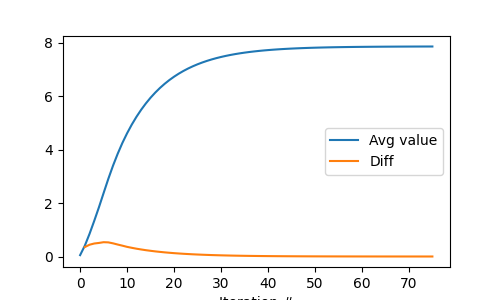

In [40]:
class GreedyPolicyIterator:
    """
    Policy iteration by applying dynamic policy evaluation with greedification steps
    """
    def __init__(self, env: GridWorld, policy_helper: PolicyHelper):
        self.env = env
        self.policy_helper = policy_helper
        
    def iterate(self, gamma: float, num_policy_iterations: Optional[int] = None,
                num_evaluation_iterations: Optional[int] = None,
                vis_interval: Optional[int] = None, vis_delay=1.):
        if vis_interval is not None:
            self.policy_helper.render(figure_title=f'Policy: Iteration 0')
        k = 0  # iteration counter
        converged = False  # we'll return whether it converged or not
        prev_values = None  # will keep a copy of previous values each iteration to check convergence
        avg_values = [] # store average value for each iteration to visualize convergence
        while True:
            # Evaluate the policy
            evaluator = DynamicPolicyEvaluator(self.env, self.policy_helper.policy)
            # NOTE: From Sutton and Barto
            # https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf
            # page 97, policy evaluation converges faster if we initialise the values with
            # the values of the previous policy. This is also necessary for value iteration to
            # work.
            values, _, policy_eval_converged = evaluator.evaluate(
                gamma, num_evaluation_iterations, init_values=prev_values)
            if not policy_eval_converged and num_evaluation_iterations is None:
                print(f"Warning: Policy evaluation did not converge for step {k}")
            # Keep a copy of the policy to check for convergence
            prev_policy = self.policy_helper.policy.copy()
            # For each state, evaluate argmax of the state-action value function,
            # and based on that, update the policy for that state
            for state_ix, _ in np.ndenumerate(values):
                # Estimated state-action value function. ie E[R_{t+1} + gamma * v(S_{t+1}) | s, a]
                # We'll fill this in for each action
                q_sa = []
                for action in Actions:
                    # `er_sa` is the expectation value of reward given state and action
                    # aka E[R_{t+1} | s, a]
                    next_state_probabilities, er_sa = self.env.evaluate_state_action(
                        state_ix, action)
                    # Compute `ev_sa` aka E[v(S_{t+1}) | s, a]
                    ev_sa = 0
                    for next_state_ix, p_s in next_state_probabilities.items():
                        ev_sa += p_s * values[next_state_ix]
                    # Append the result for this action to q_sa. We will argmax over actions
                    q_sa.append(er_sa + gamma * ev_sa)
                best_action = max(zip(Actions, q_sa), key=lambda x: x[1])[0]
                # Clear the policy for this state...
                self.policy_helper.policy[state_ix[0], state_ix[1], :] *= 0
                # ... and select the best action
                self.policy_helper.policy[state_ix[0], state_ix[1], best_action.value] = 1.
            # Update the record of average value at each iteration
            avg_values.append(values.mean())
            k += 1
            # Visualize
            if vis_interval is not None and (k % vis_interval) == 0:
                self.policy_helper.render(
                    figure_title=f'Policy: Iteration {k}, Avg value: {avg_values[-1]:.2f}', redraw=True)
                sleep(vis_delay)
            # Stop if num_iterations is reached
            if num_policy_iterations is not None and k == num_policy_iterations:
                break
            # Or if stopping condition is reached
            if prev_values is not None and np.allclose(prev_values, values, rtol=1e-4):
                converged = True
                break
            # Keep a copy of the values to check convergence
            prev_values = values.copy()

        return avg_values, converged
    

GAMMA = 0.9
env = GridWorld(8, 8, num_goals=5, num_holes=5)
policy_helper = PolicyHelper.uniformly_random(env)
# policy_helper = PolicyHelper.uniform(env, Actions.DOWN)
env.render()
iterator = GreedyPolicyIterator(env, policy_helper)
avg_values, converged = iterator.iterate(
    GAMMA, num_policy_iterations=1000, num_evaluation_iterations=1,
    vis_interval=1, vis_delay=0.05)
print(f"Policy iteration did {'' if converged else 'not '}converge")

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(avg_values, label='Avg value')
ax.plot(range(1, len(avg_values)), np.diff(avg_values, 1), label='Diff')
ax.set_xlabel('Iteration #')
ax.legend()
fig.canvas.draw()

## Value Iteration

Value Iteration can be done by setting `num_evaluation_iterations = 1` in `PolicyIterator.iterate`. For illustration purposes here is a `ValueIterator` class for doing value iteration explicitly.

<IPython.core.display.Javascript object>


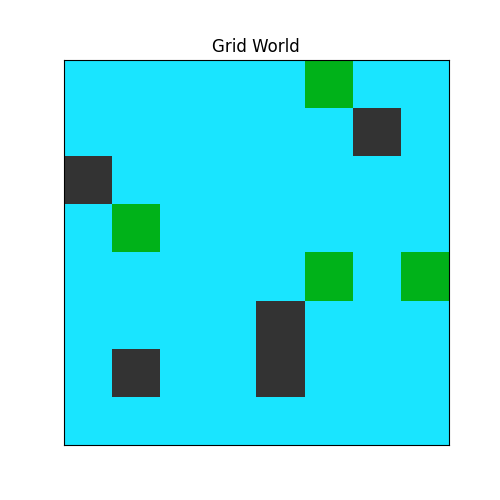

<IPython.core.display.Javascript object>


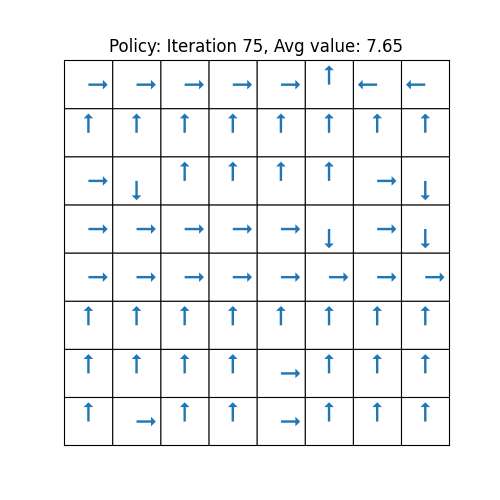

Policy iteration did converge


<IPython.core.display.Javascript object>


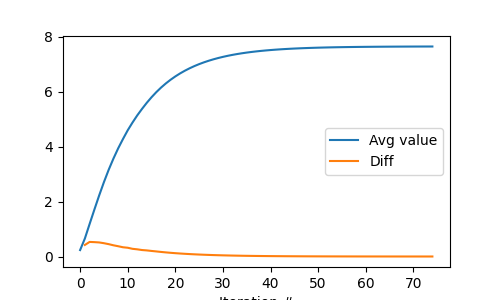

✓ Values from value iteration DO match values from policy iteration


In [41]:
class ValueIterator:
    def __init__(self, env: GridWorld, policy_helper: PolicyHelper):
        self.env = env
        self.policy_helper = policy_helper
        
    def iterate(self, gamma: float, num_value_iterations: Optional[int] = None,
                vis_interval: Optional[int] = None, vis_delay=1.):
        if vis_interval is not None:
            self.policy_helper.render(figure_title=f'Policy: Iteration 0')
        # Initiate values to be all 0
        values = np.zeros(self.env.shape)
        k = 0  # iteration counter
        converged = False  # we'll return whether it converged or not
        prev_values = None  # will keep a copy of previous values each iteration to check convergence
        avg_values = [] # store average value for each iteration to visualize convergence
        while True:
            new_values = np.zeros_like(values)
            # For each state, calculate the new value
            for state_ix, _ in np.ndenumerate(values):
                # Estimated state-action value function. ie E[R_{t+1} + gamma * v(S_{t+1}) | s, a]
                # We'll fill this in for each action
                q_sa = []
                for action in Actions:
                    # `er_sa` is the expectation value of reward given state and action
                    # aka E[R_{t+1} | s, a]
                    next_state_probabilities, er_sa = self.env.evaluate_state_action(
                        state_ix, action)
                    # Compute `ev_sa` aka E[v(S_{t+1}) | s, a]
                    ev_sa = 0
                    for next_state_ix, p_s in next_state_probabilities.items():
                        ev_sa += p_s * values[next_state_ix]
                    # Append the result for this action to q_sa. We will max over actions
                    q_sa.append(er_sa + gamma * ev_sa)
                # Apply the update rule for the value function
                new_values[state_ix] = max(q_sa)
                # For visualization purposes, we'll also update the policy, but it is not needed for
                # value iteration
                best_action = max(zip(Actions, q_sa), key=lambda x: x[1])[0]
                # Clear the policy for this state...
                self.policy_helper.policy[state_ix[0], state_ix[1], :] *= 0
                # ... and select the best action
                self.policy_helper.policy[state_ix[0], state_ix[1], best_action.value] = 1.
            # Update the values
            values = new_values
            # Update the record of average value at each iteration
            avg_values.append(values.mean())
            k += 1
            # Visualize
            if vis_interval is not None and (k % vis_interval) == 0:
                self.policy_helper.render(
                    figure_title=f'Policy: Iteration {k}, Avg value: {avg_values[-1]:.2f}', redraw=True)
                sleep(vis_delay)
            # Stop if num_iterations is reached
            if num_value_iterations is not None and k == num_value_iterations:
                break
            # Or if stopping condition is reached
            if prev_values is not None and np.allclose(prev_values, values, rtol=1e-4):
                converged = True
                break
            # Keep a copy of the values to check convergence
            prev_values = values.copy()

        return avg_values, converged, k
        

GAMMA = 0.9
env = GridWorld(8, 8, num_goals=5, num_holes=5)
env.render()

# First let's use policy iteration (we won't visualize this one)
policy_helper = PolicyHelper.uniformly_random(env)
iterator = GreedyPolicyIterator(env, policy_helper)
avg_values, converged = iterator.iterate(
    GAMMA, num_policy_iterations=1000, num_evaluation_iterations=1)
policy_from_policy_iteration = policy_helper.policy.copy()

# Then let's do value iteration (we will visualize this one)
policy_helper = PolicyHelper.uniformly_random(env)
iterator = ValueIterator(env, policy_helper)
avg_values, converged, _ = iterator.iterate(
    GAMMA, num_value_iterations=1000,
    vis_interval=1, vis_delay=0.05)
policy_from_value_iteration = policy_helper.policy.copy()
print(f"Policy iteration did {'' if converged else 'not '}converge")

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(avg_values, label='Avg value')
ax.plot(range(1, len(avg_values)), np.diff(avg_values, 1), label='Diff')
ax.set_xlabel('Iteration #')
ax.legend()
fig.canvas.draw()

# Check that policy iteration outcome is the same as value iteration
# It's possible for two policies to have the same value so we should
# compare the values, not the policies
values_from_policy_iteration = evaluate_policy_analytically(env, policy_from_policy_iteration, GAMMA)
values_from_value_iteration = evaluate_policy_analytically(env, policy_from_value_iteration, GAMMA)
    
if np.allclose(values_from_value_iteration, values_from_policy_iteration, rtol=1e-8):
    print("✓ Values from value iteration DO match values from policy iteration")
else:
    print("✘ Values from value iteration do NOT match values from policy iteration")
    print(f"... max diff was {np.abs(values_from_value_iteration - values_from_policy_iteration).max()}")

## Prioritised Sweeping

In `ValueIterator` we are doing synchronous dynamic program. Let's modify it a bit so that instead of updating all states at once, we update one state at a time. And we choose which state to update by picking the one with the largest Bellman error.

Below I'll implement this, and do some comparisons with the synchronous version.

<IPython.core.display.Javascript object>


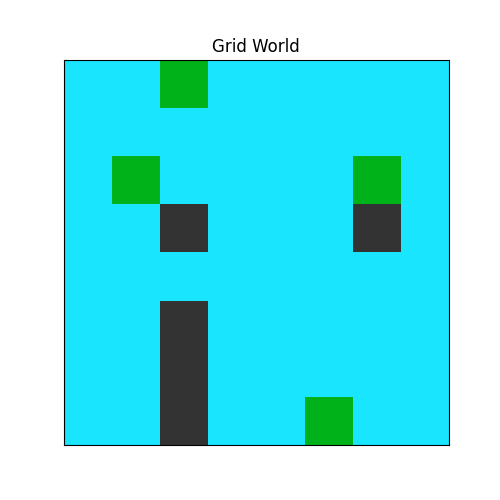

<IPython.core.display.Javascript object>


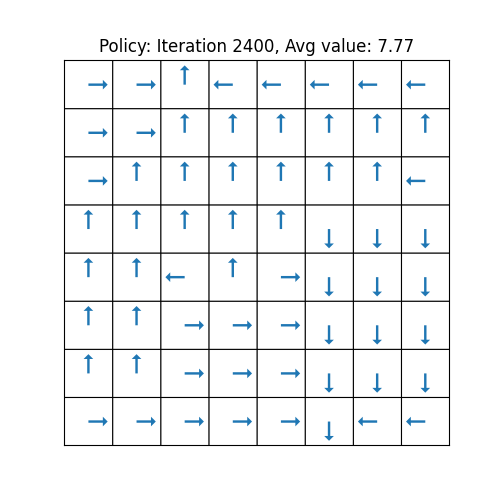

Policy iteration did converge


<IPython.core.display.Javascript object>


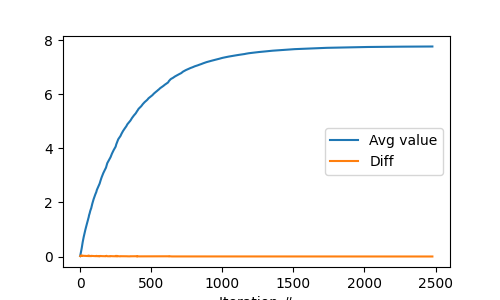

Synchronous value iteration required 4672 updates, while prioritised sweeping required 2479
✓ Values from prioritised sweeping DO match values from synchronous value iteration


In [42]:
from typing import List, Tuple


class PrioritisedAsyncValueIterator:
    def __init__(self, env: GridWorld, policy_helper: PolicyHelper):
        self.env = env
        self.policy_helper = policy_helper
        
    def iterate(self, gamma: float, num_value_iterations: Optional[int] = None,
                vis_interval: Optional[int] = None, vis_delay=1.):
        self.policy_helper.render(figure_title=f'Policy: Iteration 0')
        # Initiate values to be all 0
        values = np.zeros(self.env.shape)
        k = 0  # iteration counter
        converged = False  # we'll return whether it converged or not
        prev_values = None  # will keep a copy of previous values each iteration to check convergence
        avg_values = [] # store average value for each iteration to visualize convergence

        # Initialise Bellman errors
        bellman_errors = self.compute_bellman_errors(values, gamma)
        
        # Now iterate
        while True:
            # Keep a copy of previous policy to check convergence
            prev_policy = self.policy_helper.policy.copy()
            # Get state with largest bellman_error
            state_ix = np.unravel_index(bellman_errors.argmax(), bellman_errors.shape)
            # Get state-action values for each action in this state
            q_sa = self.get_state_action_value(values, state_ix, gamma)
            # Update the value function
            values[state_ix] = max(q_sa)
            # Update the Bellman errors
            bellman_errors = self.update_bellman_errors(bellman_errors, values, state_ix, gamma)
            # For visualization purposes, we'll also update the policy, but it is not needed for
            # value iteration
            best_action = max(zip(Actions, q_sa), key=lambda x: x[1])[0]
            # Clear the policy for this state...
            self.policy_helper.policy[state_ix[0], state_ix[1], :] *= 0
            # ... and select the best action
            self.policy_helper.policy[state_ix[0], state_ix[1], best_action.value] = 1.
            
            # Update the record of average value at each iteration
            avg_values.append(values.mean())
            k += 1
            # Visualize
            if vis_interval is not None and (k % vis_interval) == 0:
                self.policy_helper.render(
                    figure_title=f'Policy: Iteration {k}, Avg value: {avg_values[-1]:.2f}',
                    redraw=True)
                sleep(vis_delay)
            # Stop if num_iterations is reached
            if num_value_iterations is not None and k == num_value_iterations:
                break
            # Or if stopping condition is reached
            if prev_values is not None and np.allclose(prev_values, values, rtol=1e-4):
                converged = True
                break
            # Keep a copy of the values to check convergence
            prev_values = values.copy()

        return avg_values, converged, k
    
    def compute_bellman_errors(self, values: np.ndarray, gamma: float) -> np.ndarray:
        """
        Compute Bellman errors for all states
        """
        bellman_errors = np.zeros(self.env.shape)
        for state_ix, _ in np.ndenumerate(values):
            # Get state-action values for each action in this state
            q_sa = self.get_state_action_value(values, state_ix, gamma)
            # Fill in the Bellman error
            bellman_errors[state_ix] = abs(max(q_sa) - values[state_ix])
        return bellman_errors
    
    def update_bellman_errors(
            self, bellman_errors: np.ndarray, values: np.ndarray,
            state_ix: Tuple[int, int], gamma: float) -> np.ndarray:
        """
        Update Bellman errors for the state_ix, and states adjacent to it
        We will make use of the fact that we are working with MDPs where the model is known
        """
        adjacent_states = set([
            state_ix,
            (min(state_ix[0] + 1, self.env.shape[0] - 1), state_ix[1]),
            (max(state_ix[0] - 1, 0), state_ix[1]),
            (state_ix[0], min(state_ix[1] + 1, self.env.shape[1] - 1)),
            (state_ix[0], max(state_ix[1] - 1, 0)),
        ])
        for adj_state_ix in adjacent_states:
            # Get state-action values for each action in this state
            q_sa = self.get_state_action_value(values, adj_state_ix, gamma)
            # Update the Bellman error
            bellman_errors[adj_state_ix] = abs(max(q_sa) - values[adj_state_ix])
        return bellman_errors
    
    def get_state_action_value(
            self, values: np.ndarray, state_ix: Tuple[int, int], gamma: float) -> List[float]:
        """
        Given a state index, return a list of estimated state_action_values, one for each action.
        NOTE: This is a similar snippet to what can be found in the iterate method of
        ValueIterator. We just need to use it twice here, so it's neater to put it in
        its own method
        """
        # Estimated state-action value function. ie E[R_{t+1} + gamma * v(S_{t+1}) | s, a]
        # We'll fill this in for each action
        q_sa = []
        for action in Actions:
            # `er_sa` is the expectation value of reward given state and action
            # aka E[R_{t+1} | s, a]
            next_state_probabilities, er_sa = self.env.evaluate_state_action(
                state_ix, action)
            # Compute `ev_sa` aka E[v(S_{t+1}) | s, a]
            ev_sa = 0
            for next_state_ix, p_s in next_state_probabilities.items():
                ev_sa += p_s * values[next_state_ix]
            # Append the result for this action to q_sa. We will max over actions
            q_sa.append(er_sa + gamma * ev_sa)
        return q_sa

    
GAMMA = 0.9
env = GridWorld(8, 8, num_goals=5, num_holes=5)
env.render()
    
# First let's use synchronous ValueIteration (we won't visualize this one)
policy_helper = PolicyHelper.uniformly_random(env)
iterator = ValueIterator(env, policy_helper)
avg_values, converged, num_iters = iterator.iterate(GAMMA)
policy_from_sync = policy_helper.policy.copy()
# Synchronous version has |S| updates per iteration
num_updates_sync = num_iters * np.prod(env.shape)

# Then let's do prioritized sweeping (we will visualize this one)
policy_helper = PolicyHelper.uniformly_random(env)
iterator = PrioritisedAsyncValueIterator(env, policy_helper)
avg_values, converged, num_updates_async = iterator.iterate(
    GAMMA, num_value_iterations=10000,
    vis_interval=100, vis_delay=0.05)
policy_from_async = policy_helper.policy.copy()
print(f"Policy iteration did {'' if converged else 'not '}converge")

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(avg_values, label='Avg value')
ax.plot(range(1, len(avg_values)), np.diff(avg_values, 1), label='Diff')
ax.set_xlabel('Iteration #')
ax.legend()
fig.canvas.draw()

print(f"Synchronous value iteration required {num_updates_sync} updates, while prioritised sweeping required {num_updates_async}")

# Check that both outcomes are the same
# It's possible for two policies to have the same value so we should
# compare the values, not the policies
values_from_sync = evaluate_policy_analytically(env, policy_from_sync, GAMMA)
values_from_async = evaluate_policy_analytically(env, policy_from_async, GAMMA)
    
if np.allclose(values_from_async, values_from_sync, rtol=1e-8):
    print("✓ Values from prioritised sweeping DO match values from synchronous value iteration")
else:
    print("✘ Values from prioritised sweeping do NOT match values from synchronous value iteration")
    print(f"... max diff was {np.abs(values_from_async - values_from_sync).max()}")